In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_absolute_error

plt.style.use('fivethirtyeight')

In [2]:
data = pd.read_csv("hyperplane/rotatingHyperplane.data", sep=" ", header=None)
data.columns = ["V{}".format(i) for i in range(1, 11)]
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
0,0.397174,0.347518,0.294057,0.506484,0.115967,0.770536,0.659893,0.156747,0.378202,0.139763
1,0.275030,0.075388,0.610592,0.954931,0.274069,0.190202,0.001299,0.683527,0.486260,0.487515
2,0.233156,0.889909,0.038327,0.592379,0.655174,0.119839,0.652477,0.984323,0.206738,0.374650
3,0.277937,0.340915,0.265790,0.116670,0.136830,0.546089,0.494619,0.015384,0.358995,0.242478
4,0.254909,0.777916,0.225022,0.983103,0.803619,0.836315,0.163104,0.637497,0.008760,0.631190


In [3]:
labels = pd.read_csv("hyperplane/rotatingHyperplane.labels", header=None)[0].values
labels

array([0, 0, 1, ..., 1, 0, 1])

In [4]:
n_obs = len(data) // 10
data_first = data.iloc[:n_obs]
labels_first = labels[:n_obs]
data_last = data.iloc[-n_obs:]
labels_last = labels[-n_obs:]

# Modele regresji logistycznej
Stworzymy osobne modele regresji logistycznej na danych z poczatku i końca zbioru danych. Istnieje przypuszczenie, że rozkład zmiennych może się zmieniać w czasie i wobec tego zweryfkujemy czy uzasadnione jest stosowanie modelu stworzonego na początkowych danych do predykcji późniejszych obserwacji.

Dane są zrównoważone, zatem do oceny jakości klasyfikatora będziemy używali skuteczności.

In [5]:
x_train_first, x_test_first, y_train_first, y_test_first = train_test_split(data_first, labels_first)
clf_first = LogisticRegression(solver="lbfgs")
clf_first.fit(x_train_first, y_train_first)
print("Accuracy of a first classifier on first data", accuracy_score(clf_first.predict(x_test_first), y_test_first))

Accuracy of a first classifier on first data 0.897


In [6]:
x_train_last, x_test_last, y_train_last, y_test_last = train_test_split(data_last, labels_last)
clf_last = LogisticRegression(solver="lbfgs")
clf_last.fit(x_train_last, y_train_last)
print("Accuracy of first classifier on last data", accuracy_score(clf_first.predict(x_test_last), y_test_last))
print("Accuracy of new classifier on last data", accuracy_score(clf_last.predict(x_test_last), y_test_last))

Accuracy of first classifier on last data 0.643
Accuracy of new classifier on last data 0.8698


Wygląda na to, że występuje zmiana zależności y od x w naszych danych, bo całkiem dobry klasyfikator na wczesnych danych zupełnie nie radzi sobie na danych nowszych.

# Intersection distance
## Różnice w rozkładach zmiennych
Zanim zaczniemy badać zachowanie odbydwu modeli zastanowimy się nad różnicą w rozkładzie zmiennych, na których robimy predykcję między początkowymi i końcowymi danymi. W tym celu obliczymy tzw. intersection distance, który oblicza z grubsza na ile rozkłady prawdopodobieństwa zmiennych są od siebie oddalne. Wartość ta jest równa 1, kiedy zmienne mają rozłączne nośniki.

In [85]:
def intersection_distance(values_1, values_2, n_bins=30, plot=False, rwidth=None, varname=""):
    """
    Calculates intersection distance between two sets of values.
    It is close to 0 for variables from the same distribution, close to 1 if distribution are completely differen"
    """
    n_1, n_2 = len(values_1), len(values_2)
    min_value = min(min(values_1), min(values_2))
    max_value = max(max(values_1), max(values_2))
    heights_first, _ = np.histogram(values_1, bins=n_bins, range=(min_value, max_value))
    heights_second, _ = np.histogram(values_2, bins=n_bins, range=(min_value, max_value))
    intersection_distances = list()
    
    if plot:
        plt.hist(values_1, bins=n_bins, range=(min_value, max_value), rwidth=rwidth, alpha=0.7, density=True, label="first data")
        plt.hist(values_2, bins=n_bins, range=(min_value, max_value), rwidth=rwidth, alpha=0.7, density=True, label="last data")
        plt.title("Distribution of a variable {}".format(varname))
        plt.ylim((0, 1.5))
        plt.legend()
        plt.show()
        
    
    for i in range(n_bins):
        intersection_distances.append(min(heights_first[i]/n_1, heights_second[i]/n_2))

    return 1 - sum(intersection_distances)

Text(0.5, 0, 'Variable name')

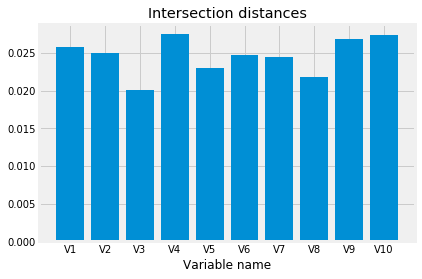

In [86]:
distances = [intersection_distance(x_train_first[colname].values, x_train_last[colname].values) 
            for colname in data.columns]
plt.bar(data.columns, distances)
plt.title("Intersection distances")
plt.xlabel("Variable name")

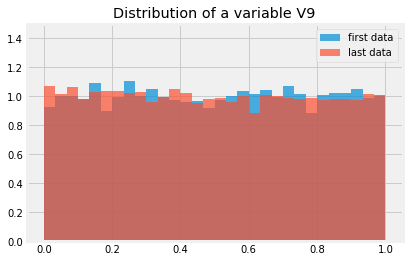

0.026866666666666927

In [87]:
intersection_distance(x_train_first["V9"].values, x_train_last["V9"].values, plot=True, varname="V9")

Porównując histogramy trudno ocenić skąd duża różnica w rozkładzie zmiennej. Wydaje mi się, że różnica ta może być przypadkowa i statystycznie nieistotna, a rozkład zmiennej dla początkowych i końcowych danych jest jednostajny na przedziale (0, 1).

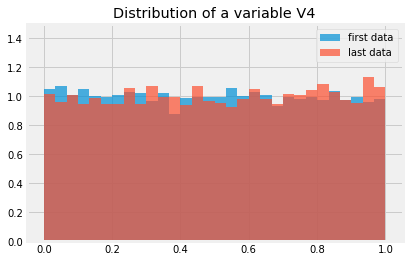

0.027466666666666528

In [88]:
intersection_distance(x_train_first["V4"].values, x_train_last["V4"].values, plot=True, varname="V4")

W tym przypadku trend jest bardziej widoczny. Zmienne nadal mają rozkład w przybliżeniu jednostajny, jednak widać że wartości kolumy V4 z poczatku danych są nieco większe niż wartości z końca.

## Różnice w rozkładzie rezyduów
Zobaczmy jak wyglądają różnice w rozkładzie rezyduów pierwszego modelu na pierwszym vs na drugim zbiorze danych.

In [16]:
res_1 = clf_first.predict_proba(x_test_first)[:, 1] - y_test_first
res_2 = clf_first.predict_proba(x_test_last)[:, 1] - y_test_last
res_distance = intersection_distance(res_1, res_2)
print("Distance between residuals:", res_distance)

Distance between residuals: 0.2547999999999998


# Różnice w PDP Plotach
Policzymy PDP ploty dla wszystkch zmiennych obydwu modeli i zbadamy jak bardzo różnią się one dla poszczególnych zmiennych.

In [17]:
def partial_dependency(data, model, colname, k=10, plot=False, min_value=None, max_value=None):
    """Plots average Ceteris Paribus profile for sample population (k observations) from data"""
    
    def get_proba(model, person, colname, colvalue):
        new_person = pd.DataFrame([person.values], columns=data.columns)
        new_person[colname] = colvalue
        return model.predict_proba(new_person)[0][0]

    min_value = min_value or np.quantile(data[colname].dropna(), 0.01, interpolation="higher")
    max_value = max_value or np.quantile(data[colname].dropna(), 0.99, interpolation="lower")
    values = np.linspace(min_value, max_value, 100)

    probas_list = [[get_proba(model, person, colname, value) for value in values] 
                   for _, person in data.sample(k).iterrows()]
    mean_probas = [np.mean(values) for values in zip(*probas_list)]
    
    if plot:
        plt.plot(values, mean_probas)
        plt.title("Partial dependency plot")
        plt.xlabel(colname)
        plt.ylabel("Marriage probability")

    return mean_probas

In [18]:
pdp_distances = list()
for colname in tqdm(data.columns):
    pdp_1 = partial_dependency(data, clf_first, colname)
    pdp_2 = partial_dependency(data, clf_last, colname)
    pdp_distances.append(mean_absolute_error(pdp_1, pdp_2))

100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


Text(0.5, 0, 'Variables')

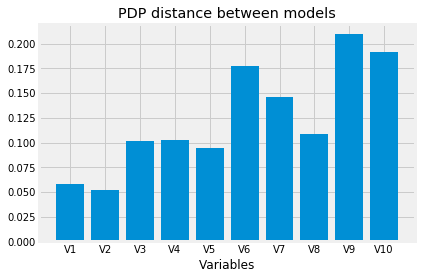

In [19]:
plt.bar(data.columns, pdp_distances)
plt.title("PDP distance between models")
plt.xlabel("Variables")

Dzięki tym wartościom możemy być w stanie zdiagnozować to co się dzieje z danymi. Widzimy teraz, dla jakich zmiennych brzegowe zachowanie modeli jest zupełnie inne. Moglibyśmy teraz przyjrzeć się im nieco dokładniej i być może spróbować odpowiedzieć na pytanie dlaczego odpowiedź modelu ze względu na te predyktory zmieniła się dla późniejszych danych. 